# CS3244 Assignment 1

We have seen the mathematical derivation of linear regression in class. In this problem, we shall convert that abstract understanding into implementation. You are encouraged to read this [introduction to linear algebra using PyTorch](https://d2l.ai/chapter_preliminaries/linear-algebra.html) before attempting if you have no prior experience with PyTorch.

In [ ]:
import matplotlib.pyplot as plt
import requests
import torch

In [ ]:
test_seed = 0

class TestCaseError(Exception):
    pass

def test_allclose(input, other):
    if input.shape != other.shape:
        raise TestCaseError("Wrong dimension")
    if not torch.allclose(input, other, atol=0.0002):
        raise TestCaseError("Wrong solution")
    return True

### Problem 0

Let us start with some administrative matters. Follow the instruction [here](https://docs.google.com/document/d/1-D06Tb-ylRNM5ja6iAuB5kxOGDybJOVLZvqEvzczH4Y/edit?usp=sharing) to set up your notebook .

From a probablistic perspective, we assume that there are some true weights $w_*$ that governs the relationship between inputs $X$ and targets $t$. In particular, $t\sim\mathcal{N}(w_*^\top x, \sigma^2)$. The `generate_1d_linear_data` function implements this sampling process. Specifically, it takes $w_*$ as `weights_true`, $m$ as `num_samples`, and outputs $X$ as `inputs` and $t$ as `targets`. Certainly, we are not going to have this generative process in practice, but it is useful to use such toy examples for enchancing our understanding of a topic. 

In [ ]:
def generate_1d_linear_data(weights_true, num_samples):
    uniform = torch.distributions.uniform.Uniform(0, 5)
    normal = torch.distributions.normal.Normal(0, 1)
    inputs, _ = torch.sort(uniform.sample([num_samples, 1]))
    augmented_inputs = torch.hstack((torch.ones(num_samples, 1), inputs))
    targets = augmented_inputs @ weights_true + normal.sample([num_samples])
    return inputs, targets

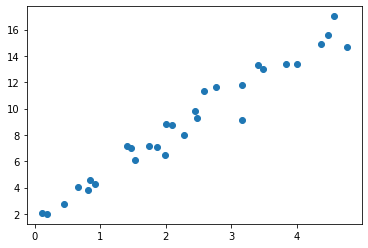

In [ ]:
torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)

fig, ax = plt.subplots()
ax.scatter(inputs, targets)
fig.show()

Recall that the goal of linear regression is to find a $\hat{w}$ that best approximates the unknown $w_*$ using $X$ and $t$. As such, you should not use $w_*$ from here onwards.

### Problem 1

A common trick used to deal with the bias (or offset) term is to augment the input vector $x=[x_1,\dots,x_D]$ with $x_0=1$. This allows us to simplify the computation of

$$y(x)=w_0+\sum_{i=1}^D w_i x_i,$$

into a simple vector multiplication $y(x)=w^\top x$. Implement the `augment_linear_inputs` function with the following specifications:

**Input**

- `inputs`: the input matrix $X\in\mathbb{R}^{N\times D}$

**Output**

- the augmented input matrix where each row starts with 1

In [ ]:
def augment_linear_inputs(inputs):
    #print(inputs)
    padding = torch.nn.ConstantPad1d(padding=(1,0), value=1)
    augmented_inputs = padding(inputs)
    #print(augmented_inputs)
    return augmented_inputs

In [ ]:
# Public testcase for augment_linear_inputs

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 3)

augmented_inputs = augment_linear_inputs(inputs)
expected_augmented_inputs = torch.tensor([[1.0000, 2.4813], [1.0000, 3.8411], [1.0000, 0.4424]])
is_correct = test_allclose(augmented_inputs, expected_augmented_inputs)
print(f"Public testcase for augment_linear_inputs: {is_correct}")

Public testcase for augment_linear_inputs: True


### Problem 2

Implement the `error_gradient` function with the following specifications:

**Input**

- `weights_current`: the current weights $\hat{w}\in\mathbb{R}^{D+1}$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times(D+1)}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 

**Output**

- the gradient of the error function $\nabla_w E(w)$

**Notes**

Note that the input is already augmented, hence the $D+1$ in dimension. On a separate note, you should write your code to work for arbitrary dimension $D$. This will be utilized from Problem 6 onwards. 

In [ ]:
def error_gradient(weights_current, inputs, targets):
    numRows = inputs.size(dim=0)
    numCols = weights_current.size(dim=0)

    weightsReshaped = torch.reshape(weights_current, (-1,)).float()
    inputsReshaped = torch.reshape(inputs, (numRows,-1)).float()
    targetsReshaped = torch.reshape(targets, (-1,)).float()

    #print("weightsReshaped is\n", weightsReshaped)
    #print(weightsReshaped.size())
    #print("\ninputsReshaped is\n", inputsReshaped)
    #print(inputsReshaped.size())
    #print("\ntargetsReshaped is\n", targetsReshaped)
    #print(targetsReshaped.size())

    inputsTransposed = torch.transpose(input=inputsReshaped, dim0=0, dim1=1)
    firstTerm = torch.negative(torch.matmul(inputsTransposed,targetsReshaped))  ## -X^T @ Y
    secondTerm = torch.matmul(torch.matmul(inputsTransposed, inputsReshaped), weightsReshaped)  ## (X^T @ X) @ W
    finalTerm = torch.add(firstTerm, secondTerm)
    finalTermReshaped = torch.reshape(finalTerm, (-1,))

    #print("\ngradient is\n", finalTermReshaped)
    #print(finalTermReshaped.size())
    return finalTermReshaped

In [ ]:
# Public testcase for error_gradient

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 3)
weights_current = torch.tensor([1., 1.])
augmented_inputs = augment_linear_inputs(inputs)

gradient = error_gradient(weights_current, augmented_inputs, targets)
expected_gradient = torch.tensor([-17.1925, -50.4709])
is_correct = test_allclose(gradient, expected_gradient)
print(f"Public testcase for error_gradient: {is_correct}")

Public testcase for error_gradient: True


### Problem 3

Implement the `gradient_descent` function with the following specificiations:

**Input**

- `weights_initial`: the initial guess for the weights $\hat{w}\in\mathbb{R}^{D+1}$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times(D+1)}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 
- `learning_rate`: the learning rate $\alpha$
- `num_iterations`: the number of updates to the weights

**Output**

- the learned weights $\hat{w}$ after performing gradient descent on the data

In [ ]:
def gradient_descent(weights_initial, inputs, targets, learning_rate, num_iterations):
    for counter in range (num_iterations):
        weights_initial = weights_initial - (learning_rate * error_gradient(weights_initial, inputs, targets))

    return weights_initial

In [ ]:
# Public testcase for gradient_descent

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 3)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rate = 0.001
num_iterations = 20

weights_learned = gradient_descent(weights_initial, augmented_inputs, targets, learning_rate, num_iterations)
expected_weights_learned = torch.tensor([1.2787, 1.8135])
is_correct = test_allclose(weights_learned, expected_weights_learned)
print(f"Public testcase for gradient_descent: {is_correct}")

Public testcase for gradient_descent: True


### Problem 4

Implement the `visualize_linear_model` function with the following specificiations. You are encouraged to read the [Basic Usage](https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py) and [Pyplot Tutorial](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) if you have no prior experience with Matplotlib. When plotting, adhere to the OO-style described in the [Coding Styles](https://matplotlib.org/stable/tutorials/introductory/usage.html#coding-styles) section.

**Input**

- `weights_current`: the weights vector $\hat{w}\in\mathbb{R}^2$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 2}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 

**Output**

- a `matplotlib` figure with
    - a <font color="red">red</font> scatter plot of `inputs` and `targets`
    - a <font color="green">green</font> line plot described by the `weights` vector

**Example**

If done right, your output should look like this (without the scribbles).

![index.png](https://drive.google.com/uc?export=view&id=1AajXyexn7yoy8GHZDX8z99356OhMSNC1)

**Notes**

This only works for $D=1$.

In [ ]:
def wLinear(weights, nonAugmentedInputs):
    return weights[0] + weights[1] * nonAugmentedInputs    # returns a column vector


def visualize_linear_model(weights_learned, inputs, targets):
    nonAugmentedInputs = (inputs[:, 1:])    # remove the augmented column of 1s

    fig, ax = plt.subplots()
    ax.set_title('Visualizing Linear Model')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.scatter(nonAugmentedInputs,targets, color = 'red')
    ax.plot(nonAugmentedInputs, wLinear(weights_learned, nonAugmentedInputs), color='green')    # x-axis should be nonAugmentedInputs, since original data does not have '1' augmented to it
    return fig

Let us see your code in action. The following code set the initial weights and hyperparameters, compute the learned weights using your `gradient_descent` function, and visualize the learned curve using your `visualize_model` function. If your curve fits the data and the `weights_learned` are close to $w_*=[2.0,3.0]$, you code is most likely correct.

Model weights are [1.7107689380645752, 3.080777406692505]


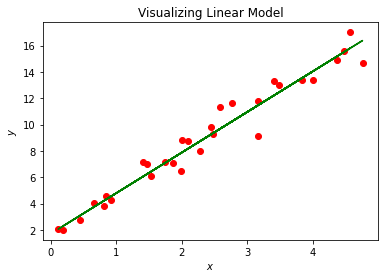

In [ ]:
torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rate = 0.001
num_iterations = 20

weights_learned = gradient_descent(weights_initial, augmented_inputs, targets, learning_rate, num_iterations)
print(f"Model weights are {weights_learned.tolist()}")

fig = visualize_linear_model(weights_learned, augmented_inputs, targets)
fig.show()

### Problem 5

In the previous code block, we have arbitrarily set $\alpha=0.001$. Let us explore the effect of the learning rate in more detail. To do so, we want to visualize the error over the training process. Implement the `gradient_descent_with_logger` with the following specifications.

**Input**

- `weights_initial`: the initial guess for the weights $\hat{w}\in\mathbb{R}^{D+1}$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times(D+1)}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 
- `learning_rate`: the learning rate $\alpha$
- `num_iterations`: the number of updates to the weights

**Output**

- the learned weights $\hat{w}$ after performing gradient descent on the data
- a PyTorch 1D-tensor of the error after each iteration of gradient descent (including the error before and after the training)

In [ ]:
def fitHypothesisLinear(weightsLearned, nonAugmentedInputs, numFeatures):
    numRows = nonAugmentedInputs.size(dim=0)
    numCols = nonAugmentedInputs.size(dim=1)

    predictedOutput = torch.empty(size=(numRows, numCols))

    # each weight must be matched to it's corresponding feature
    for i in range (numFeatures):
        #print(weightsLearned[i])
        #print(nonAugmentedInputs[:,i])
        #print(weightsLearned[i] * nonAugmentedInputs[:,i])
        predictedOutput[:, i] = weightsLearned[i] * nonAugmentedInputs[:,i]

    # Sum up along all columns, to give a Nx1 column vector
    # each row entry denotes the PREDICTED OUTPUT given some INPUT
    predictedOutput = predictedOutput.sum(axis=1, keepdim=True)
    return predictedOutput


def getError(trueOutputs, predictedOutputs):
    #print("trueOutputs is", trueOutputs)
    #print("\npredictedOutputs is", predictedOutputs)
    #print(torch.reshape(predictedOutputs, (-1,)))

    subError = torch.sub(trueOutputs, torch.reshape(predictedOutputs, (-1,)))
    #print("\nsubTensor is", subError)

    squaredSub = torch.square(subError)
    return (0.5 * squaredSub.sum())       # include 1/2 term as per loss function


def gradient_descent_with_logger(weights_initial, inputs, targets, learning_rate, num_iterations):
    #print("weights_initial is", weights_initial)
    #print("\ninputs is", inputs )
    #print("\ntargets is", targets)

    # add trainingError before ANY training is done
    trainingError = [getError(targets, fitHypothesisLinear(weights_initial, inputs, inputs.size(dim=1)))]

    # begin training
    for counter in range (num_iterations):
        weights_initial = weights_initial - (learning_rate * error_gradient(weights_initial, inputs, targets))
        #print('\nweightsLearned for {}th iteration is'.format(counter), weights_initial)

        predictedOutputs = fitHypothesisLinear(weights_initial, inputs, inputs.size(dim=1))
        #print("\npredictedOutputs is", predictedOutputs, "\n")
        trainingError += [getError(targets, predictedOutputs)]


    #print("\n trainingError is", trainingError)
    weights_learned = weights_initial
    return weights_learned, torch.Tensor(trainingError)

In [ ]:
# Public testcase for gradient_descent_with_logger

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rate = 0.001
num_iterations = 5

_, error = gradient_descent_with_logger(weights_initial, augmented_inputs, targets, learning_rate, num_iterations)
expected_error = torch.tensor([597.8280, 349.5298, 206.3568, 123.8006, 76.1970, 48.7477])
is_correct = test_allclose(error, expected_error)
print(f"Public testcase for gradient_descent_with_logger: {is_correct}")

Public testcase for gradient_descent_with_logger: True


### Problem 6

To visualize the effect of the learning rate $\alpha$, we want to plot the error curve for multiple learning rates. Implement the `visualize_error` function with the following specificiations.

**Input**

- `weights_initial`: the initial guess for the weights $\hat{w}\in\mathbb{R}^2$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 2}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 
- `learning_rates`: an array of learning rates that we want to include in the visualization of the error curve
- `num_iterations`: the number of updates to the weights

**Output**

- a `matplotlib` figure with
    - a line plot for each error curve
    - a legend associating the learning rate to each error curve

**Example**

If done right, your output should look like this (without the scribbles).

![index.png](https://drive.google.com/uc?export=view&id=13Stf3A-77xOu6xreK-eQFuNS4W_yHfmm)

In [ ]:
def convertToList (numIterations):
   iterationList = []
   
   for i in range(numIterations + 1):
       iterationList.append(i)

   return (iterationList)


def visualize_errors(weights_initial, inputs, targets, learning_rates, num_iterations):
    fig, ax = plt.subplots()
    ax.set_title('Visualizing Learning Rates')
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Error")

    errorLearningRates = []
    for learningRate in learning_rates:
        _, errorLearningRate = gradient_descent_with_logger(weights_initial, inputs, targets, learningRate, num_iterations)    # returns vector, corresponding to error rates as iterations increases FOR SOME learning rate
        errorLearningRates.append(errorLearningRate)

    for loopCounter, errorLearningRate in enumerate(errorLearningRates):
        convertedList = errorLearningRate.tolist()
        ax.plot(convertToList(num_iterations), convertedList, label = f'Learning Rate = {learning_rates[loopCounter]}')

    ax.legend()
    return fig

Let us see your code in action again. The following code set the initial weights, provide a set of learning rates, and visualize the error curves for these learning rates. Can you give an explanation for your observation?

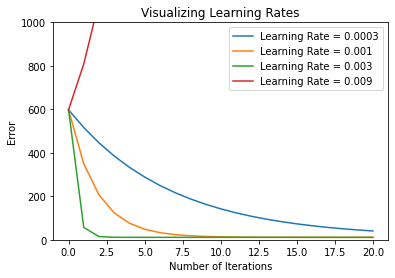

In [ ]:
# Public testcase for visualize_errors

torch.manual_seed(test_seed)
weights_true = torch.tensor([2., 3.])
inputs, targets = generate_1d_linear_data(weights_true, 30)
augmented_inputs = augment_linear_inputs(inputs)
weights_initial = torch.tensor([1., 1.])
learning_rates = [ 0.0003, 0.001, 0.003, 0.009 ]
num_iterations = 20

fig = visualize_errors(weights_initial, augmented_inputs, targets, learning_rates, num_iterations)
fig.axes[0].set_ylim([0, 1000])
fig.show()

Let us now shift our focus to fitting nonlinear functions. As mentioned prior to Problem 1,

> From a probablistic perspective, we assume that there are some true weights $w_*$ that governs the relationship between inputs $X$ and targets $t$. In particular, $t\sim\mathcal{N}(w_*^\top x, \sigma^2)$.

Instead of $y(x)=w_*^\top x$, let us assume that the underlying process $t(x)=a+bx+\ln(x^c)$ for some weight vector $w_*=[a,b,c]=[3,-2,5]$.

In [ ]:
def generate_1d_nonlinear_data(weights_true, num_samples):
    uniform = torch.distributions.uniform.Uniform(1, 5)
    normal = torch.distributions.normal.Normal(0, 0.1)
    inputs, _ = torch.sort(uniform.sample([num_samples, 1]), dim=0)
    targets = weights_true[0] * torch.ones([num_samples]) + \
              weights_true[1] * inputs[:,0] + \
              torch.log(inputs[:,0] ** weights_true[2]) + \
              normal.sample([num_samples])
    return inputs, targets

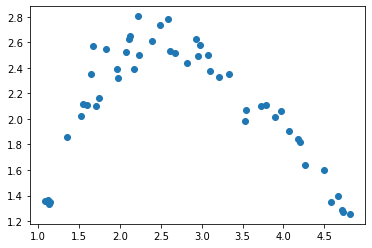

In [ ]:
torch.manual_seed(test_seed)
weights_true = torch.Tensor([3., -2., 5.])
inputs, targets = generate_1d_nonlinear_data(weights_true, 50)

fig, ax = plt.subplots()
ax.scatter(inputs, targets)
fig.show()

Also from Problem 1,

> Certainly, we are not going to have this generative process in practice, but it is useful to use such toy examples for enchancing our understanding of a topic. 

As usual, you should not use your knowledge of $w_*$ from here onwards. To fit this nonlinear curve, we need to use a basis function. Assuming we know the form, but not the exact parameters, of the underlying process, can you see why $\phi(x)=[1,x,\ln(x)]$ is a good choice of basis function?

### Problem 7

Implement the `basis_function` function with the following specifications.

**Input**

- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 1}$

**Output**

- the mapped input $\phi(X)\in\mathbb{R}^{N\times 3}$ where each row is $\phi(x)=[1,x,\ln(x)]$

In [ ]:
def transformBasis(dataPoint):
    return [1, dataPoint.item(), torch.log(dataPoint).item()]

def basis_function(inputs):
    numRows = inputs.size(dim=0)
    mappedInputs = torch.empty(size=(numRows, 3))

    for i in range(numRows):
        mappedInputs[i, :] = torch.FloatTensor(transformBasis(inputs[i,:]))

    return mappedInputs

In [ ]:
# Public testcase for basis_function

torch.manual_seed(test_seed)
weights_true = torch.Tensor([3., -2., 5.])
inputs, targets = generate_1d_nonlinear_data(weights_true, 3)

mapped_inputs = basis_function(inputs.clone())
expected_mapped_inputs = torch.tensor([[1.0000, 1.3539, 0.3030], [1.0000, 2.9850, 1.0936], [1.0000, 4.0729, 1.4044]])
is_correct = test_allclose(mapped_inputs, expected_mapped_inputs)
print(f"Public testcase for basis_function: {is_correct}")

Public testcase for basis_function: True


### Problem 8

Implement the `visualize_nonlinear_model` function with the following specificiations.

**Input**

- `weights_current`: the weights vector $\hat{w}\in\mathbb{R}^3$ 
- `inputs`: the input matrix $X\in\mathbb{R}^{N\times 3}$ 
- `targets`: the target vector $t\in\mathbb{R}^N$ 

**Output**

- a `matplotlib` figure with
    - a <font color="red">red</font> scatter plot of `inputs` and `targets`
    - a <font color="green">green</font> line plot described by the `weights` vector

**Example**

If done right, your output should look like this (without the scribbles).

![index.png](https://drive.google.com/uc?export=view&id=12zoYCphS93pgAMNn5-zjV9atFcaUXvSp)

**Notes**

This only works for your choice of basis function.

In [ ]:
def reverseBasis(basisData):
    return[basisData[1]]

def wNonLinear(weights_learned, basis_inputs):
    return weights_learned[0] * basis_inputs[:,0] + weights_learned[1] * basis_inputs[:,1] + weights_learned[2] * basis_inputs[:,2]


def visualize_nonlinear_model(weights_learned, basis_inputs, targets):
    # get the original inputs
    numRows = basis_inputs.size(dim=0)
    originalInputs = torch.empty(size=(numRows, 1))
    
    for i in range (numRows):
        originalInputs[i,:] = torch.FloatTensor(reverseBasis(basis_inputs[i,:]))

    fig, ax = plt.subplots()
    ax.set_title('Visualizing Non-Linear Model')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    ax.scatter(originalInputs, targets, color = 'red')
    ax.plot(originalInputs, wNonLinear(weights_learned, basis_inputs), color='green')

    return fig

Let us put everything together. Note that if you implement `gradient_descent_with_logger` correctly, you should not need to make any modification on those functions here.

Model has an error of 12.644


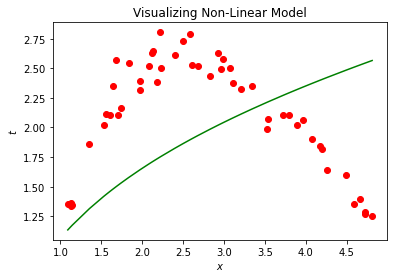

In [ ]:
# Public testcase for visualize_nonlinear_model

torch.manual_seed(test_seed)
weights_true = torch.Tensor([3., -2., 5.])
inputs, targets = generate_1d_nonlinear_data(weights_true, 50)
mapped_inputs = basis_function(inputs)
weights_initial = torch.Tensor([1., 1., 1.])
learning_rate = 0.001
num_iterations = 20

weights_learned, errors = gradient_descent_with_logger(weights_initial, mapped_inputs, targets, learning_rate, num_iterations)
print(f"Model has an error of {errors[-1]:.3f}")
fig = visualize_nonlinear_model(weights_learned, mapped_inputs, targets)
fig.show()

This looks really bad, and the error is really high. Perhaps looking at the error curve can help illuminate the issue.

In [ ]:
def plot_error_curve(errors, learning_rate):
    fig, ax = plt.subplots()
    ax.set_title('Errors of Non-Linear Model')
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("$Error$")
    ax.plot(errors, label = f'Learning Rate = {learning_rate}')
    ax.legend()
    ax.set_ylim(0, 30)
    return fig

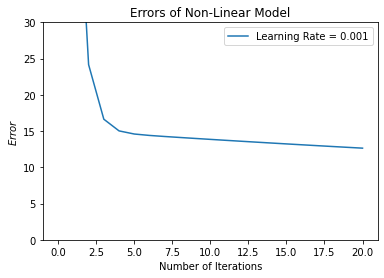

In [ ]:
fig = plot_error_curve(errors, learning_rate)
fig.show()

### Problem 9

It seems that the error is still decreasing slowly. Perhaps changing some hyperparamters might help. Change the hyperparameters in the `fit_nonlinear_model` function so that your model obtain an error of less than 0.6.

In [ ]:
def fit_nonlinear_model(inputs, targets):
    mapped_inputs = basis_function(inputs)
    weights_initial = torch.Tensor([1.0, 1.0, 1.0])
    ### start modifying the code here ###
    learning_rate = 0.0030
    num_iterations = 1450
    ### stop modifying the code here ###
    weights_learned, errors = gradient_descent_with_logger(weights_initial, mapped_inputs, targets, learning_rate, num_iterations)
    fitted_figure = visualize_nonlinear_model(weights_learned, mapped_inputs, targets)
    return weights_learned, errors, fitted_figure

Model has an error of 0.565, which is less than the required error of 0.6.


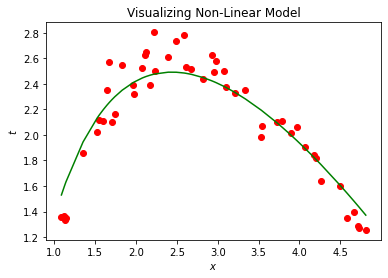

In [ ]:
# Public testcase for fit_nonlinear_model

torch.manual_seed(test_seed)
weights_learned, errors, fitted_figure = fit_nonlinear_model(inputs, targets)
error_relative_string = "more" if errors[-1] > 0.6 else "less"
print(f"Model has an error of {errors[-1]:.3f}, which is {error_relative_string} than the required error of 0.6.")
fitted_figure.show()

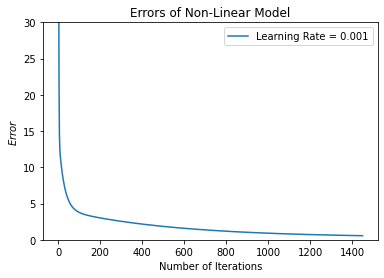

In [ ]:
error_figure = plot_error_curve(errors, learning_rate)
error_figure.show()